# Import Dependencies and Define Functions

In [20]:
#!/usr/bin/env python
# coding: utf-8

# # Import Dependencies and Define Functions

%matplotlib notebook

#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import os
from tkinter import Tk
from tkinter.filedialog import askdirectory
from iapws import IAPWS97 as steam_prop
import matplotlib.animation as animation
from matplotlib.widgets import Slider, RadioButtons, Button
import itertools
import PIL
import time
from scipy.stats import linregress
from statistics import mean
np.seterr(all='raise')


#Define critical pressure ratio
alpha = 0.55

#Define a function that calculates the density for a given pressure and temperature
def calc_rho(p, t):
    
    #convert psia to MPA
    pressure = p*0.00689476

    #convert farenheit to Kelvin
    temp = (t - 32)*5/9 + 273.15

    #get the density 
    rho = steam_prop(P=pressure, T=temp).rho
    
    #convert density from kg/M^3 to lb/ft^3
    rho = rho*0.062428
    
    return rho

#piecewise linear fit
def piecewise_linear(x, y0, y1, b0, b1, b2):
    global x0
    global x1

    return np.piecewise(x, 
                        [x < x0, 
                         (x >= x0) & (x < x1), 
                         x >= x1], 
                        [lambda x: b0*x + y0, 
                         lambda x: b1*x + y1-b1*x1,
                         lambda x: b2*x + y1-b2*x1])

    
#Function for getting user input on curve fitting
def user_plot_fit(x0_start, x1_start, title, xdata, ydata, xlabel, ylabel, xunits, yunits):
    
    #re-initialize global x0 - assumption for first breakpoint
    #re-initialize global x1 - assumption for second breakpoint
    global x0 
    global x1
    x0 = x0_start
    x1 = x1_start

    #optimize piecewise fit with user-defined breakpoints
    p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)

    #Define range for governor demand model
    model_x = np.linspace(-1, 100, 100)

    # Create figure and axis objects
    fig, ax = plt.subplots()

    #add plot labels
    plt.title(f"Use Sliders to Adjust Curve Fit!\n\n{title}")
    plt.ylabel(f"{ylabel}\n({yunits})")
    plt.xlabel(f"{xlabel}\n({xunits})")

    #plot historical/design data
    data, = plt.plot(xdata, ydata, 'o')

    #plot piecewise curve fit
    fit, = plt.plot(model_x, piecewise_linear(model_x, *p))

    #left, bottom, width, height
    ax_break1 = plt.axes([0.25, 0.05, 0.50, 0.02])
    ax_break2 = plt.axes([0.25, 0.02, 0.50, 0.02])

    #Create slider animations for the breakpoints
    slider1 = Slider(ax_break1, 'Breakpoint 1', 0, 100, valinit=x0_start)
    slider2 = Slider(ax_break2, 'Breakpoint 2', 0, 100, valinit=x1_start)
    
    def update(val):
        global x0
        global x1
        x0 = slider1.val
        x1 = slider2.val
        # update curve
        p, e = optimize.curve_fit(piecewise_linear, xdata, ydata)
        fit.set_ydata(piecewise_linear(model_x, *p))
        # redraw canvas while idle
        fig.canvas.draw_idle()

    # call update function on slider value change
    slider1.on_changed(update)
    slider2.on_changed(update)

    #show plot
    plt.tight_layout(pad=4)
    plt.show()

    #Save results to DataFrame
    dictionary = {
        xlabel : ax.get_children()[1]._x,
        ylabel : ax.get_children()[1]._y
        }
     
    model_df = pd.DataFrame(dictionary)
    model_df.to_csv(f"projects/{project}/{ylabel}_model.csv")
    
    return model_df

#define a function that gets the flow regime for a given jratio nd pratio
def get_regime(jratio, pratio):
    # return 1 if "Neither Choked"
    # return 2 if "Governor Choked"
    # return 3 if "Nozzle Choked"
    # return 4 if "Both Choked"
    
    global alpha
    
    #Define the intersection of the curves
    triple_point = alpha + (alpha - 1) *0.55**2/alpha
    
    #if jratio is to the right of the triple point, test for neither choked or nozzle choked
    if jratio > 0.55:
        
        #define the limit below which the nozzle is choked
        limit = alpha*jratio*(jratio-(-4*alpha+jratio**2+4)**0.5)/(2*(alpha-1))
        
        #test if the pratio is in "neither choked" or "nozzle choked" regime
        if pratio > limit:
            return 1
        else:
            return 3
    
    #if jratio is to the left of the triple point, test for neither choked, governor choked, or both choked
    else:
        
        #define the limit below which both are choked
        limit = triple_point/alpha*jratio
        
        #if the pratio is below the limit, the flow is "both choked"
        if pratio < limit:
            return 4
        
        #if not, define the limit below which the governover is choked
        else:
            limit = alpha + (alpha-1)*jratio**2/alpha
            
            #if the pratio is below the limit, the flow is "governor choked"
            if pratio < limit:
                return 2
            else:
                return 1

#Define a function that calculates the Bowl Pressure Ratio from flow regime, jratio, and pratio
#case 1 neither choked
# pbr = 1/2(-jr^2 + pxr + sqrt(4*jr^2 + jr^4 - 2*jr^2*pxr + pxr^2))
# flow = jr*sqrt(rho_in*(1-pbr))

#case 2 governor choked
#pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))
# flow = jr*sqrt(rho_in*(1-alpha)) 

#case 3 nozzle choked
#pbr = 1/2( - jr^2/(1-alpha) - jrsqrt(4+jr^2-4*alpha)/(-1+alpha))
#flow = jr*sqrt(rho_in*(1-pbr))

#case 4 nozzle choked
#pbr = jr
#flow = jr*sqrt(rho_in*(1-alpha))

def calc_pbr(regime, j_ratio, p_ratio):
        
        #Use notebook alpha
        global alpha
        
        if regime == 1:
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2 + p_ratio + (4*j_ratio**2 + j_ratio**4 - 2*p_ratio*j_ratio**2 + p_ratio**2)**0.5)

        elif regime == 2:
            #pbr = 1/2(pxr + sqrt(4*jr^2 +pxr^2 - 4*jr^2*alpha))

            #Calculate bowl pressure
            pbr = 0.5*(p_ratio + (4*j_ratio**2 + p_ratio**2 - 4*j_ratio**2*alpha)**0.5)

        elif regime == 3:
            #pbr = 1/2( - jr^2/(1-alpha) - (jr/(-1+alpha))*sqrt(4+jr^2-4*alpha))
            
            #Calculate bowl pressure
            pbr = 0.5*(-j_ratio**2/(1-alpha) -(j_ratio/(alpha-1))*((4+j_ratio**2 - 4*alpha)**0.5))

        elif regime == 4:
            
            #pbr =??????

            #Calculate bowl pressure
            pbr = j_ratio
        
        return pbr

    
#Define a function that calculates the flow in KPPH from flow regime, inlet pressure, governor j, and pb
def calc_flow(regime, pi, pb, jgv, r):

        #Use notebook alpha
        global alpha
        
        if (regime == 1):

            flow = 3.6*jgv*(r*(pi-pb))**0.5
        
        elif regime ==3:
            
            flow = 3.6*jgv*(r*(pi-pb))**0.5

        elif regime == 2:

            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        elif regime ==4:
            
            #PLACEHOLDER
            flow = 3.6*jgv*(r*(alpha*pi))**0.5
        
        return flow
    

#Define a function that calculates the Jgov from flow regime, bowl pressure, inlet pressure, inlet density, and flow
def solve_j(regime, pi, pb, r, flow):
    
    #Use notebook alpha
    global alpha
    
    if (regime == 1):

        #flow = 3.6*jgv*(r*(pi-pb))**0.5
        jgv = flow/3.6/((r*(pi-pb))**0.5)

    elif regime ==3:

        #flow = 3.6*jgv*(r*(pi-pb))**0.5
        jgv = flow/3.6/(r*(pi-pb))**0.5

    elif regime == 2:

        #flow = 3.6*jgv*(r*(alpha*pi))**0.5
        jgv = flow/3.6/(r*(alpha*pi))**0.5

    elif regime ==4:
        
        #PLACEHOLDER
        #flow = 3.6*jgv*(r*(alpha*pi))**0.5
        jgv = flow/3.6/(r*(alpha*pi))**0.5

    return jgv

    
# ## Define Trim Curves
# The lifts to evaluate at are pre-determined
def define_trim(res, trim_guesses):
    
    global gov_no

    #guesses = [[gv1 0, 50, 100, 25....], [gv2 0, 50, 100, 25...]

    # initialize
    trims_list = []
    
    for x in range(gov_no):
        
        lift_list = [0,100]
        area_list = [0,100]
        
        #Define the lifts
        for i in range(res):
            lift_list.insert(i+1, 100/(1+res)*(i+1))
        
            area_list.insert(i+1, trim_guesses[x][i])
    
        trims_list.append(lift_list)
        trims_list.append(area_list)

    #Create a list of column titles for Pandas dataframe
    titles = []
    for i in range(gov_no):
        titles.append("GV"+str(i+1)+" lift")
        titles.append("GV"+str(i+1)+" area")

    #Define a dictionary of the governor trim curves
    dictionary = {}
    for i in range(gov_no):
        dictionary.update({titles[2*i] : trims_list[2*i]})
        dictionary.update({titles[2*i+1] : trims_list[2*i+1]})

    #Use dictionary to create a pandas dataframe
    gv_trim_df = pd.DataFrame(dictionary)

    #Save Dataframe to csv
    gv_trim_df.to_csv(f"projects/{project}/gov_trim_curve.csv")
    
    return gv_trim_df


def calc_ks(performance_df, gov_noz_ratios):
    #---------------------------------------------
    #---------------------------------------------
    #
    # Calculate the govenor and nozzle flow coeffiecients for the given governor_k / nozzle_k ratio
    #
    #---------------------------------------------
    #---------------------------------------------
    global gov_no
    
    #determine the flow at 100% governor demand 
    max_flow = performance_df.loc[performance_df["Governor Demand"] == 100, "Steam Flow Target"].to_list()[0]

    #Determine the throttle pressure at 100% governor demand
    max_tp = performance_df.loc[performance_df["Governor Demand"] == 100, "Throttle Pressure"].to_list()[0]

    #determine the p_ratio at 100% governor demand
    max_p_ratio = performance_df.loc[performance_df["Governor Demand"] == 100, "Px/Pi"].to_list()[0]

    #determine the bowl densities at 100% governor demand   
    max_rho = performance_df.loc[performance_df["Governor Demand"] == 100, "Inlet Density"].to_list()[0]
    
    #determine the first stage pressure at 100% governor demand
    max_fsp = performance_df.loc[performance_df["Governor Demand"] == 100, "First Stage Pressure"].to_list()[0]

    
    max_regime = []
    max_pb = []
    max_rb = []
    factor = 0
    #For each governor valve, determine the flow regime at 100% governor demand
    for i in range(gov_no):
        max_regime.append(get_regime(gov_noz_ratios[i], max_p_ratio))
        
        #Calculate the bowl pressure
        max_pb.append(max_tp * calc_pbr(max_regime[i], gov_noz_ratios[i], max_p_ratio))
        
        #determine the bowl densities at 100% governor demand
        max_rb.append(max_rho*max_pb[i]/max_tp)
                      
        if max_regime[i] < 3:
        #nozzle not choked
                      
            factor = factor + (max_rb[i]*(max_pb[i] - max_fsp))**0.5


        else:
        #nozzle choked
            
            factor = factor + (max_rb[i]*alpha*max_pb[i])**0.5

                      
    #Calculate the necessary jgov and jnoz
    try:
        noz_k = max_flow/3.6/factor
    except:
        print(f"factor = {factor}, max_flow = {max_flow}, max_tp = {max_tp}, max_p_ratio = {max_p_ratio}, max_rho = {max_rho}, max_fsp = {max_fsp}")
    
    #Create list for governor valve Ks
    gov_ks = []
    for i in range(gov_no):
        gov_ks.append(noz_k*gov_noz_ratios[i])
    
    return (gov_ks, noz_k)

def unravel_parameters(parameters):
    # This function takes a list with the following structure:
    # [Avg Gov/Noz Ratio, GV1 gov/noz var...GVX gov/noz var, GV1 trim decrement factors...GVX Trim decrement factors]
    # and returns a list of the individual govnernor valve K / nozzle K ratios, and a list of
    # lists with the following form [[GV1 trim guesses], [GV2 trim guesses]...[GVx trim guesses]]
    
    # Determine how many trim points are being used
    res = int((len(parameters) - (gov_no+1))/gov_no)
    
    # Get the first gov_no+1 parameters and turn it into individual gov/noz size ratios
    gov_noz_inputs = parameters[:(gov_no+1)]
    
    # Create empty list to hold the individual gov / noz k ratios
    gov_noz_ratios = []
    
    # For each governor valve, the gov/noz k ratio is (average gov/noz ratio)*(individual variance)
    for x in range(gov_no):
        gov_noz_ratios.append(gov_noz_inputs[x+1] / gov_noz_inputs[0])
        
    # The trim-related parameters are at the tail of the guess list. Take all but the first gov_no+1 parameters
    trim_parameters = initial_guess[(gov_no+1):]
    
    # Create empty list to hold the lists of govenror trim factors
    trim_factors = []

    # Split the trim related parameters into individual lists for each governor valve
    for i in range(gov_no):
        sliceObj = slice(i*res, (i+1)*res)
        trim_factors.append(trim_parameters[sliceObj])

    # Create empty list to hold the final list of trim guesses in %
    trim_guess = []

    # Iterate over the number of governor valves
    for x in range(gov_no):

        # Create empty list to hold the current governor valve's trim guesses in %
        trim_guess_indiv = []

        # If only one point in the lift vs. area curve need to be defined, use an alternative calculation
        if res == 1:

            # The guess for the first trim point is 100*(first trim factor)
            trim_guess_indiv.append(100*trim_factors[x][0])
        else:

            # The guess for the first trim point is 100*(first trim factor)
            trim_guess_indiv.append(100*trim_factors[x][0])

            # The remaining trim points are (previous area)*(next trim factor)
            for i in range(res-1):
                trim_guess_indiv.append(trim_guess_indiv[i]*trim_factors[x][i+1])

        # Reverse the trim guesses so that the smaller lifts are at the start of the list
        trim_guess_indiv.reverse()

        # Add the individual trim points to the over trim guess, then move on
        trim_guess.append(trim_guess_indiv)
              
    return (gov_noz_ratios, trim_guess)



def calc_performance(parameters, performance_df, plot_flag, iteration):

    global gov_no
    
    # Determine how many trim points are being used
    res = int((len(parameters) - (gov_no+1))/gov_no)
    
    (gov_noz_ratios, trim_guess) = unravel_parameters(parameters)
    (gov_k_list, noz_k) = calc_ks(performance_df, gov_noz_ratios)
    trim_df = define_trim(res, trim_guess)

    #---------------------------------------------
    #---------------------------------------------
    #
    # Calculate Flow Coefficients and Predicted Flows 
    #
    #---------------------------------------------
    #---------------------------------------------

    global single_dmd_df
    global seq_demand_df
    
    gov_dmd = performance_df.loc[:,"Governor Demand"].to_list()
    p_ratio = performance_df.loc[:, "Px/Pi"].to_list()
    tp = performance_df.loc[:, "Throttle Pressure"].to_list()
    rho = performance_df.loc[:, "Inlet Density"].to_list()

    for i in range(gov_no):

        #ITERATE OVER GVs
        #re-initialize problem
        single_j_list = []
        single_jratio_list = []
        single_region_list = []
        single_pb_list = []
        single_f_list = []

        seq_j_list = []
        seq_jratio_list = []
        seq_region_list = []
        seq_pb_list = []
        seq_f_list = []

        for x in range(len(gov_dmd)):

                #----------------------------------------------------------
                #Calculate the jratio and flow regime for single valve mode
                #----------------------------------------------------------

                #Calculate the valve lift
                try:
                    single_lift = np.interp(gov_dmd[x], single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"])
                except:
                    print("single_lift")
                    
                #Calculate the valve area
                try:
                    single_j_list.append(gov_k_list[i]/100*np.interp(single_lift, trim_df[f"GV{i+1} lift"], trim_df[f"GV{i+1} area"]))
                except:
                    print("single_j_list")
                
                #calculate the jratio
                try:
                    single_jratio_list.append(single_j_list[x]/noz_k)
                except:
                    print("single_jratio_list")

                #determine the flow regime for each governor valve
                try:
                    single_region_list.append(get_regime(single_jratio_list[x], p_ratio[x]))
                except:
                    print("single_region_list")
                #----------------------------------------------------------
                # Calculate Pb and flow for single valve mode
                #----------------------------------------------------------
                try:
                    pbowl =  tp[x] * calc_pbr(single_region_list[x], single_jratio_list[x], p_ratio[x])
                except:
                    print("single_pbowl")
                
                single_pb_list.append(pbowl)

                #Calculate flow
                try:
                    single_f_list.append(calc_flow(single_region_list[x], tp[x], pbowl, single_j_list[x], rho[x]))
                except:
                    print("single_f_list")


                #----------------------------------------------------------
                #Calculate the jratio and flow regime for sequential valve mode
                #----------------------------------------------------------

                #Calculate the valve lift
                seq_lift = np.interp(gov_dmd[x], seq_dmd_df.iloc[:,2*i], seq_dmd_df.iloc[:,2*i+1])

                #Calculate the valve area
                seq_j_list.append(gov_k_list[i]/100*np.interp(seq_lift, trim_df[f"GV{i+1} lift"], trim_df[f"GV{i+1} area"]))
                
                #calculate the jratio
                seq_jratio_list.append(seq_j_list[x]/noz_k)

                #determine the flow regime for each governor valve
                seq_region_list.append(get_regime(seq_jratio_list[x], p_ratio[x]))

                #----------------------------------------------------------
                # Calculate Pb and flow for sequential valve mode
                #----------------------------------------------------------

                pbowl =  tp[x] * calc_pbr(seq_region_list[x], seq_jratio_list[x], p_ratio[x])
                seq_pb_list.append(pbowl)

                #Calculate flow in KPPH
                seq_f_list.append(calc_flow(seq_region_list[x], tp[x], pbowl, seq_j_list[x], rho[x]))



        performance_df[f"Single Flow Coefficient {i+1}"] = single_j_list
        performance_df[f"Single Flow Region {i+1}"] = single_region_list
        performance_df[f"Single J Ratio {i+1}"] = single_jratio_list
        performance_df[f"Single Bowl Presusre {i+1}"] = single_pb_list
        performance_df[f"Single Flow {i+1}"] = single_f_list


        performance_df[f"Sequential Flow Coefficient {i+1}"] = seq_j_list
        performance_df[f"Sequential Flow Region {i+1}"] = seq_region_list
        performance_df[f"Sequential J Ratio {i+1}"] = seq_jratio_list
        performance_df[f"Sequential Bowl Presusre {i+1}"] = seq_pb_list
        performance_df[f"Sequential Flow {i+1}"] = seq_f_list

        #ITERATE OVER GVs


    single_flow_list = []
    seq_flow_list = []

    for i in range(len(gov_dmd)):

        total_flow_single = 0
        total_flow_seq =0
        for x in range(gov_no):
            total_flow_single += performance_df[f"Single Flow {x+1}"].tolist()[i]
            total_flow_seq  += performance_df[f"Sequential Flow {x+1}"].tolist()[i]

        single_flow_list.append(total_flow_single)
        seq_flow_list.append(total_flow_seq)

    performance_df["Total Single Flow"] = single_flow_list
    performance_df["Total Sequential Flow"] = seq_flow_list

    #---------------------------------------------
    #---------------------------------------------
    #
    # END: Calculate Flow Coefficients and Predicted Flows 
    #
    #---------------------------------------------
    #---------------------------------------------

      
    #Calculate error
    error = ((performance_df["Total Single Flow"] - performance_df["Steam Flow Target"])**2 + \
            (performance_df["Total Sequential Flow"] - performance_df["Steam Flow Target"])**2).sum()
    
    #Save the plot if the current error is lowest error so far
    if plot_flag == 1:
        fig, ax = plt.subplots()

        plt.plot(performance_df["Governor Demand"], performance_df["Steam Flow Target"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Single Flow"])
        plt.plot(performance_df["Governor Demand"], performance_df["Total Sequential Flow"])
        plt.legend(["Target", "Single", "Sequential"],loc="best")
        plt.title("Steam Flow vs. Governor Demand")
        plt.xlabel("Govenor Demenad\n(%)")
        plt.ylabel("Steam Flow\n (KPPH)")
        plt.tight_layout()
        #plt.show()

        fig.savefig(f'projects/{project}/plot{iteration}.png')
        plt.close(fig)
        
        trim_df.to_csv(f'projects/{project}/trim{iteration}.csv')
        print(f"gov ks = {gov_k_list}")
        print(f"noz_k = {noz_k}")
    
    return error

Would you like to return to an existing project?(y/n)n
What would you like to call this project?uu
Couldn't make new 'projects' directory


<IPython.core.display.Javascript object>


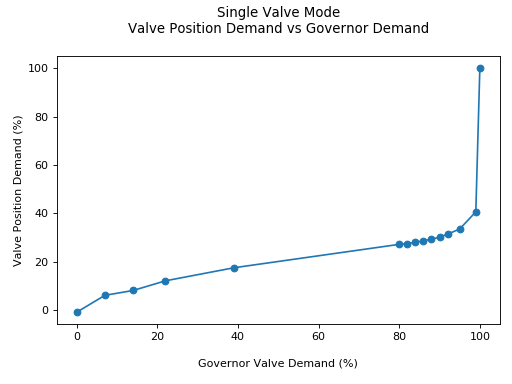

How many governor valves are there?8


<IPython.core.display.Javascript object>


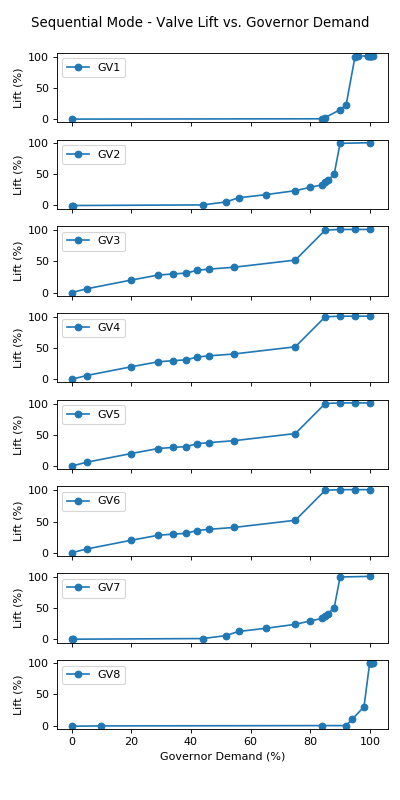

In [3]:
# # Open a Project

#Ask if user would like to open a project
open_flag = input("Would you like to return to an existing project?(y/n)")

#If user requests to open project, request project name
if open_flag == "y":
    try:
        path = askdirectory(title="Select Project Folder")
    except:
        print("File open failed.")

# In[4]:
    #get project name
    list_path = path.split(sep="/")
    open_project = list_path[-1]
    project = open_project

    #Load available dataframes
    try:
        single_dmd_df = pd.read_csv(f"projects/{open_project}/single_dmd_curve.csv")
    except:
        print("Couldn't load 'single_dmd_curve.csv' from project")
        
    try:
        seq_dmd_df = pd.read_csv(f"projects/{open_project}/sequential_dmd_curve.csv")
        #Use integer division to get number of governor valves
        gov_no = len(seq_dmd_df.columns)//2
    except:
        print("Couldn't load 'sequential_dmd_curve.csv' from project")
        
    try:
        design_df = pd.read_csv(f"projects/{open_project}/design_data.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_flow_model_df = pd.read_csv(f"projects/{open_project}/steam_flow_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        tp_model_df = pd.read_csv(f"projects/{open_project}/tp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        steam_temp_model_df = pd.read_csv(f"projects/{open_project}/steam_temp_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
    try:
        first_stage_model_df = pd.read_csv(f"projects/{open_project}/first_stage_model.csv")
    except:
        print("Couldn't load 'design_data.csv' from project")
    
# # Define a New Project

else:
    # Get a project name from the user
    project = input("What would you like to call this project?")

    # Create a Directory for the project
    try:
        os.mkdir("projects")
    except:
        print("Couldn't make new 'projects' directory")
    try:
        os.mkdir(f"projects/{project}")
    except:
        print(f"Couldn't make new '{project}' directory")

    # Load data to define Single Mode Governor Demand to Valve Position Curve
    single_dmd_df = pd.read_csv("data/single_dmd_curve.csv")

    # Save Dataframe to csv in project folder
    single_dmd_df.to_csv(f"projects/{project}/single_dmd_curve.csv")

    # Plot the governor demand single valve curve
    fig1 = plt.plot(single_dmd_df["Governor Demand"], single_dmd_df["Valve Position Demand"], "o-")
    plt.title("Single Valve Mode\nValve Position Demand vs Governor Demand\n")
    plt.ylabel("Valve Position Demand (%)")
    plt.xlabel("\nGovernor Valve Demand (%)")
    plt.tight_layout()
    plt.show()

    # Save the figure to the project directory
    plt.savefig(f"projects/{project}/single_dmd_curve.png")


    # Load data to define Sequential Mode Governor Demand to Valve Positions Curves
    seq_dmd_df = pd.read_csv("data/sequential_dmd_curve.csv")
    
    # Get number of governor valves from the user
    gov_no = int(input("How many governor valves are there?"))

    # Save Dataframe to csv in project folder
    seq_dmd_df.to_csv(f"projects/{project}/sequential_dmd_curve.csv")
    
    # Plot trim curves
    
    # Plot will have a common x axis for all plots. Plots stacked vertically for easy compare
    fig, axes = plt.subplots(gov_no, sharex=True, figsize = (5,10))
    
    # Iterate over the number of governor valves and create a plot for each with label and legend
    for i in range(gov_no):
        axes[i].plot(seq_dmd_df.iloc[:,i*2], seq_dmd_df.iloc[:,i*2+1], 'o-', label = f"GV{i+1}" )
        axes[i].set_ylabel(f'Lift (%)')
        axes[i].legend(loc="upper left")
    
    # Set x axis label on bottom figure only
    axes[(gov_no-1)].set_xlabel('Governor Demand (%)')
    
    # Set figure title
    fig.suptitle("Sequential Mode - Valve Lift vs. Governor Demand")
    
    # Use tight layout to bring the plot under the super title [left, bottom, right, top]
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Save figure for future reference
    fig.savefig(f'projects/{project}/sequential_dmd_curve.png')
    

In [4]:
    # Load data to define the Design Performance
    design_df = pd.read_csv("data/design_data.csv")
    
    # Save dataframe to csv in the project folder
    design_df.to_csv(f"projects/{project}/design_data.csv")
    
    # Calculate the Inlet Density and Equivalent J = F/sqrt(rho*dp) based on input data
    # Create empty lists to hold calculations
    rho = []
    factor = []
    
    # Convert Dataframe to lists
    f = design_df["Steam Flow (Design)"].to_list()
    tp = design_df["Throttle Pressure (Design)"].to_list()
    fsp = design_df["First Stage Pressure (Design)"].to_list()
    t = design_df["Main Steam Temperature (Design)"].to_list()
    
    # For each data point, calculate inlet density and equivalent J
    for i in range(len(design_df)):
        rho.append(calc_rho(tp[i], t[i]))
        
        # If pressure drop is choked use alpha instead of total pressure drop
        if (tp[i] - fsp[i]) > alpha:
            dp = alpha*tp[i]
        else:
            dp = tp[i] - fsp[i]
            
        factor.append(f[i]/(rho[i]*dp)**0.5)
    
    # Add columns for inlet density and Equivalent J
    design_df["Inlet Density (Design)"] = rho
    design_df["Equivalent J (Design)"] = factor
    

In [43]:
    # Plot equivalent J vs Governor Demand
    x_axis = design_df.loc[ design_df["Governor Demand (Design)"] > 0, "Governor Demand (Design)"].to_list()
    y_axis = design_df.loc[ design_df["Governor Demand (Design)"] > 0, "Equivalent J (Design)"].to_list()
    
    # Insert point (0,0)
    x_axis.insert(0,0)
    y_axis.insert(0,0)

    # Create 100 data points for the fit
    model_x = np.linspace(min(x_axis) - 0.01*(max(x_axis) - min(x_axis)), max(x_axis) + 0.01*(max(x_axis) - min(x_axis)), 100)

    # Calculate linear fit to start with
    (slope, intercept, _, _, _) = linregress(x_axis, y_axis)
    fit_x_data = model_x
    fit_y_data = slope * model_x + intercept

    # Calculate lower boundary for outliers
    
    # The x points are the fit curve points
    lb_model_x = fit_x_data
    
    # The y-points are the fit curve points - value
    lb_model_y = fit_y_data - 0.05*mean(fit_y_data)

    # calculate upper boundary for outliers
    
    # The x points are the fit curve points
    ub_model_x = fit_x_data
    
    # The y-points are the fit curve points - value
    ub_model_y = fit_y_data + 0.05*mean(fit_y_data)
    
    # For each data point, determine if it is oustide the lower boundary or upper boundary via linear interpolation
    ll_list = np.interp( x_axis, lb_model_x, lb_model_y)
    ul_list = np.interp( x_axis, ub_model_x, ub_model_y)
    
    outlier_x_data = []
    outlier_y_data = []
    filt_x_data = []
    filt_y_data = []
    for i in range(len(y_axis)):
        if (y_axis[i] > ul_list[i]) or (y_axis[i] < ll_list[i]):
            outlier_x_data.append(x_axis[i])
            outlier_y_data.append(y_axis[i])
            filt_x_data.append(x_axis[i])
            filt_y_data.append(np.nan)
        else:
            outlier_x_data.append(x_axis[i])
            outlier_y_data.append(np.nan)
            filt_x_data.append(x_axis[i])
            filt_y_data.append(y_axis[i])
            
    


<IPython.core.display.Javascript object>


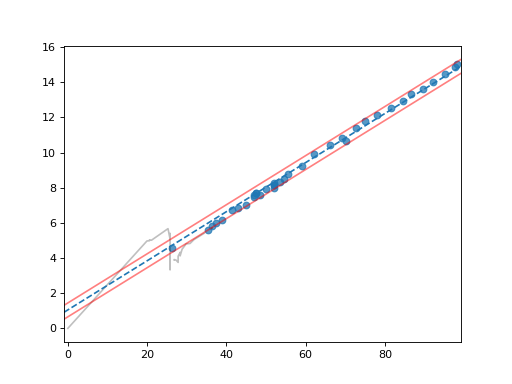

(-0.9819726563000001, 99.1792382863)

In [45]:
# Create figure and axis objects
fig, ax = plt.subplots()

# Plot data identified as outliers in gray
outliers, = plt.plot( outlier_x_data, outlier_y_data, color='black', alpha=0.25)

# Plot curve-fit as a dotted blue line
fit, = plt.plot(model_x, slope * model_x + intercept, '--')

# Plot in red, semi-opaque
lb, = plt.plot( lb_model_x, lb_model_y, color='red', alpha=0.5)

# Plot in red, semi-opaque
ub, = plt.plot( ub_model_x, ub_model_y, color='red', alpha=0.5)

# Plot data no identified as outliers in blue
filt_data = plt.scatter( filt_x_data, filt_y_data, alpha=0.75)

# Set plot range to 1% outside the values in the data
plt.xlim( min(x_axis) - 0.01*(max(x_axis) - min(x_axis)), max(x_axis) + 0.01*(max(x_axis) - min(x_axis)) )

In [ ]:
outlier_x_data.append(x_axis[i])

In [42]:
    #left, bottom, width, height
    axRadio  = plt.axes([0.4375, 0.01, 0.125, 0.2])
    butRadio = RadioButtons(axRadio, ('linear', 'x^2', 'x^0.5', 'x^3', 'x^4', 'x^y', '2-piecewise'))

    #left, bottom, width, height
    ax_tolerance = plt.axes([0.25, 0.22, 0.50, 0.02])

    #Create slider animations for the breakpoints
    slider1 = Slider(ax_tolerance, 'Outlier Tolerance', 0, 1, valinit=0.05)
    
    # [left, bottom, right, top]
    plt.tight_layout(rect=[0, 0.25, 1, 0.95])
    
    radioValue = 0
    def update(val):
        
        # Store the radio button selection in a variable
        radioValue = butRadio.value_selected

        # For each selection, pick curve fit to optimize with
        if radioValue == 'linear':            
            # Get best linear fit
            (slope_new, intercept_new, r_value, p_value, stderr) = linregress(x_axis, y_axis)
            
            # calculate y-values using fit function
            fit_x_data = model_x
            fit_y_data = slope_new * model_x + intercept_new
            
            # Calculate lower boundary for outliers
    
            # The x points are the fit curve points
            lb_model_x = fit_x_data

            # The y-points are the fit curve points - value
            lb_model_y = fit_y_data - slider1.val**mean(fit_y_data)

            # calculate upper boundary for outliers

            # The x points are the fit curve points
            ub_model_x = fit_x_data

            # The y-points are the fit curve points - value
            ub_model_y = fit_y_data + slider1.val**mean(fit_y_data)

            # For each data point, determine if it is oustide the lower boundary or upper boundary via linear interpolation
            ll_list = np.interp( x_axis, lb_model_x, lb_model_y)
            ul_list = np.interp( x_axis, ub_model_x, ub_model_y)

            outlier_x_data = []
            outlier_y_data = []
            filt_x_data = []
            filt_y_data = []
            for i in range(len(y_axis)):
                if (y_axis[i] > ul_list[i]) or (y_axis[i] < ll_list[i]):
                    outlier_x_data.append(x_axis[i])
                    outlier_y_data.append(y_axis[i])
                    filt_x_data.append(np.nan)
                    filt_y_data.append(np.nan)
                else:
                    outlier_x_data.append(np.nan)
                    outlier_y_data.append(np.nan)
                    filt_x_data.append(x_axis[i])
                    filt_y_data.append(y_axis[i])
            
            # Reset outlier data points
            outliers.set_xdata(outliers_x_data)
            outliers.set_ydata(outliers_y_data)
            
            # Reset best fit line data points
            fit.set_ydata(y_axis_new)

            # Plot lower boundary for outliers
            lb.set_ydata( lb_model_y)

            # Plot upper boundary for outliers
            ub.set_ydata( ub_model_y)
            
            # Reset filtered data points
            filt_data.set_xdata(filt_x_data)
            filt_data.set_ydata(filt_y_data)

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(slope_new) + " * x + " + '{:.3e}'.format(intercept_new))

            # redraw canvas
            fig.canvas.draw()
            fig.canvas.flush_events()

        if radioValue == 'x^0.5':            
            # Get best quadratic fit
            popt, pcov = optimize.curve_fit(root, x_axis, y_axis)

            # calculate y-values using fit function. Numpy does not allow fractional powers of negative numbers: requiring the extra math
            y_axis_new = popt[0]*(np.sign(model_x)*np.abs(model_x)**0.5) + popt[1]

            # Reset best fit line data points
            fit.set_ydata(y_axis_new)

            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(popt[0]) + " * x^0.5 + " + '{:.3e}'.format(popt[1]))

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()

        if radioValue == 'x^2':
            # Get best quadratic fit
            popt, pcov = optimize.curve_fit(quadratic, x_axis, y_axis)

            # calculate y-values using fit function
            y_axis_new = popt[0]*(model_x**2) + popt[1]*(model_x) + popt[2]

            # Reset best fit line data points
            fit.set_ydata(y_axis_new)

            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(popt[0]) + " * x^2 + " + '{:.3e}'.format(popt[1]) + " * x + " + '{:.3e}'.format(popt[2]))

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()
        if radioValue == 'x^3':
            # Get best cubic fit
            popt, pcov = optimize.curve_fit(cubic, x_axis, y_axis)

            # calculate y-values using fit function
            y_axis_new = popt[0]*(model_x**3) + popt[1]*(model_x**2) + popt[2]*(model_x) + popt[3]

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(popt[0]) + " * x^3 + " + '{:.3e}'.format(popt[1]) + " * x^2 + " + '{:.3e}'.format(popt[2]) + " * x + " + '{:.3e}'.format(popt[3]))
            
            # Reset best fit line data points
            fit.set_ydata(y_axis_new)

            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()
        if radioValue == 'x^4':
            # Get best fourth power fit
            popt, pcov = optimize.curve_fit(fourth, x_axis, y_axis)

            # calculate y-values using fit function
            y_axis_new = popt[0]*(model_x**4) + popt[1]*(model_x**3) + popt[2]*(model_x**2) + popt[3]*(model_x) + popt[4]

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(popt[0]) + " * x^4 + " + '{:.3e}'.format(popt[1]) + " * x^3 + " + '{:.3e}'.format(popt[2]) + " * x^2 + "\
                 + '{:.3e}'.format(popt[3]) + " * x + " + '{:.3e}'.format(popt[4]) )
            
            # Reset best fit line data points
            fit.set_ydata(y_axis_new)
            
            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()
        if radioValue == 'x^y':
            # Get best power fit
            popt, pcov = optimize.curve_fit(power, x_axis, y_axis)

            # calculate y-values using fit function
            
            # Numpy does not allow fractional powers of negative numbers: requiring the extra math
            y_axis_new = popt[0]*(np.sign(model_x)*np.abs(model_x)**(popt[1])) + popt[2]

            # Reset best fit line data points
            fit.set_ydata(y_axis_new)
            
            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # Display equation as the plot title
            fig.suptitle('y = ' +'{:.3e}'.format(popt[0]) + " * x^(" + '{:.3e}'.format(popt[1]) + ") + " + '{:.3e}'.format(popt[2]))

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()
        if radioValue == '2-piecewise':
            # Get best piecewise fit
            popt, pcov = optimize.curve_fit(piecewise_2, x_axis, y_axis)

            # calculate y-values using fit function
            y_axis_new = piecewise_2(model_x, *popt)

            # Reset best fit line data points
            fit.set_ydata(y_axis_new)

            # Plot lower boundary for outliers
            lb.set_ydata( y_axis_new - slider1.val*y_axis_new)

            # Plot upper boundary for outliers
            ub.set_ydata( y_axis_new + slider1.val*y_axis_new)

            # Display equation as the plot title
            fig.suptitle(popt)

            # redraw canvas while idle
            fig.canvas.draw()
            fig.canvas.flush_events()

    
    butRadio.on_clicked(update)
    slider1.on_changed(update)

    #show plot
    # [left, bottom, right, top]
    plt.tight_layout(rect=[0, 0.25, 1, 0.95])
    plt.show()

C:\Users\SESA345961\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':
C:\Users\SESA345961\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<IPython.core.display.Javascript object>


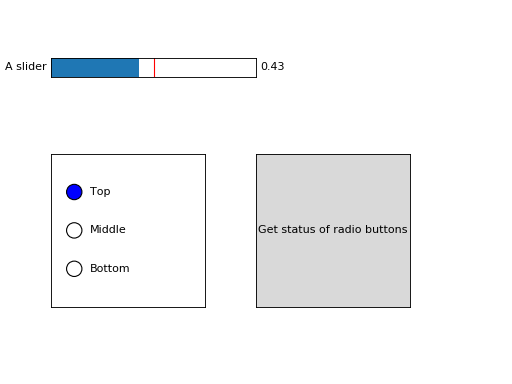

In [14]:
axSlider = plt.axes([0.1, 0.8, 0.4, 0.05])
aSlider  = Slider(axSlider,'A slider', 0,1,  valinit=0.5)

axRadio  = plt.axes([0.1, 0.2, 0.3, 0.4])
butRadio = RadioButtons(axRadio, ('Top','Middle','Bottom'))

axStatus = plt.axes([0.5, 0.2, 0.3, 0.4])
bStatus  = Button(axStatus,'Get status of radio buttons')

radioValue=0
def update(val):
    #radioValue = ???? -- Need this line of code.
    radioValue = 1
    sliderValue= aSlider.val
    print(sliderValue,radioValue)
    print(0,1)

aSlider.on_changed(update)
#bStatus.on_clicked(get_status)
plt.show()


In [15]:
print(radioValue)

0

Would you like to return to an existing project?(y/n)n
What would you like to call this project?test
Couldn't make new 'projects' directory


<IPython.core.display.Javascript object>


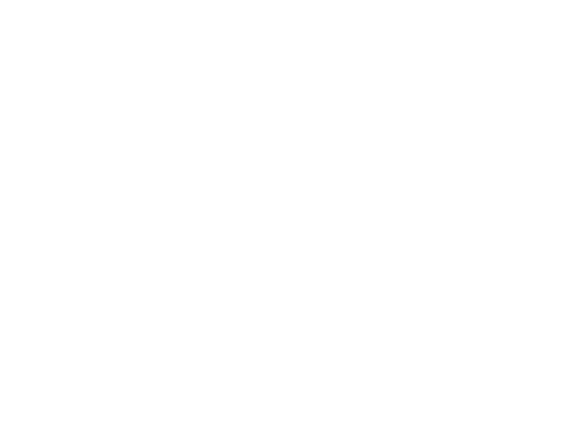

How many governor valves are there?8


<IPython.core.display.Javascript object>


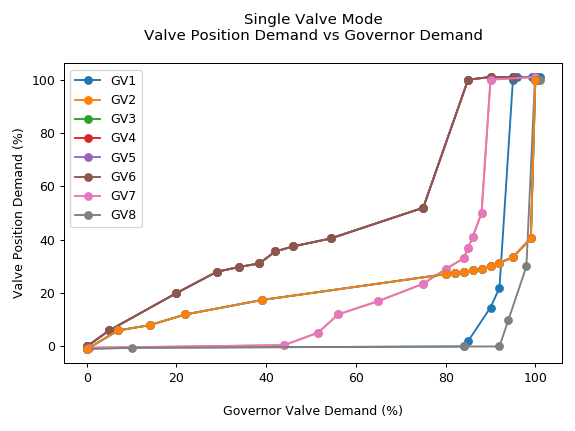

In [4]:
   
    
#     # Define Steam Flow Model
#     steam_flow_model_df = user_plot_fit(
#         33,
#         66,
#         "Steam Flow vs. Governor Demand",
#         design_df["Governor Demand (Design)"].tolist(),
#         design_df["Steam Flow (Design)"].tolist(),
#         "Governor Demand",
#         "Steam Flow",
#         "%",
#         "KPPH"
#     )

#     steam_flow_model_df.to_csv(f"projects/{project}/steam_flow_model.csv")

#     #Define Throttle Pressure Model
#     tp_model_df = user_plot_fit(
#         33,
#         66,
#         "Throttle Pressure vs. Governor Demand",
#         design_df["Governor Demand (Design)"].tolist(),
#         design_df["Throttle Pressure"].tolist(),
#         "Governor Demand",
#         "Throttle Pressure",
#         "%",
#         "psia"
#     )

#     tp_model_df.to_csv(f"projects/{project}/tp_model.csv")

#     #Define Main Steam Temperature Model
#     steam_temp_model_df = user_plot_fit(
#         33,
#         66,
#         "Steam Temperature vs. Governor Demand",
#         design_df["Governor Demand (Design)"].tolist(),
#         design_df["Main Steam Temperature"].tolist(),
#         "Governor Demand",
#         "Steam Temp",
#         "%",
#         "F"
#     )

#     steam_temp_model_df.to_csv(f"projects/{project}/steam_temp_model.csv")


#     #Define First Stage Pressure Model
#     first_stage_model_df = user_plot_fit(
#         33,
#         66,
#         "First Stage Pressure vs. Governor Demand",
#         design_df["Governor Demand (Design)"].tolist(),
#         design_df["First Stage Pressure (Design)"].tolist(),
#         "Governor Demand",
#         "First Stage Pressure",
#         "%",
#         "psia"
#     )

#     first_stage_model_df.to_csv(f"projects/{project}/first_stage_model.csv")

How governor demands do you want to evaluate with? (10 is suggested)10
How many trim points do you want to evaluate with?10


<IPython.core.display.Javascript object>


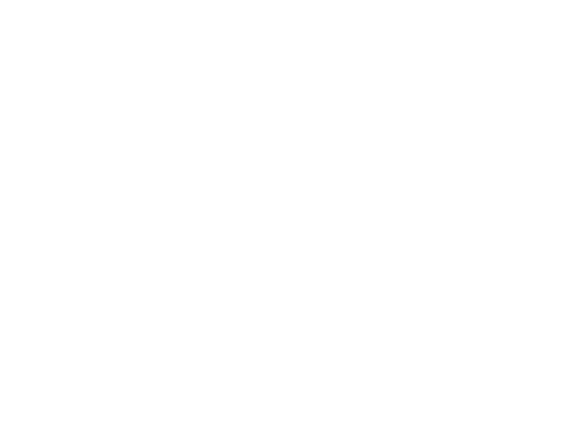

gov ks = [4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255]
noz_k = 4.885060566730255


In [56]:
#---------------------------------------------
#---------------------------------------------
#
# Make the initial guess
#
#---------------------------------------------
#---------------------------------------------

# Define the governor demands to test against

target_resolution = int(input("How governor demands do you want to evaluate with? (10 is suggested)"))
gov_dmd = np.arange(0,100+100/target_resolution, 100/target_resolution)

#Define the throttle pressure
tp = np.interp(gov_dmd, tp_model_df["Governor Demand"], tp_model_df["Throttle Pressure"])

#Define the steam temperatures
temperature = np.interp(gov_dmd, steam_temp_model_df["Governor Demand"], steam_temp_model_df["Steam Temp"])

#Define the inlet densities
rho = []
for x in range(len(gov_dmd)):
    rho.append(calc_rho(tp[x],temperature[x]))

#Define the first stage pressures
first_p = np.interp(gov_dmd, first_stage_model_df["Governor Demand"], first_stage_model_df["First Stage Pressure"])

#Define the target steam flows
flow_target = np.interp(gov_dmd, steam_flow_model_df["Governor Demand"], steam_flow_model_df["Steam Flow"])

#Define the p_ratio
p_ratio = first_p / tp

dictionary = {
    "Governor Demand" : gov_dmd,
    "Throttle Pressure" : tp,
    "Main Steam Temp" : temperature,
    "Inlet Density" : rho,
    "First Stage Pressure" : first_p,
    "Steam Flow Target" : flow_target,
    "Px/Pi" : p_ratio
}

target_df = pd.DataFrame(dictionary)
target_df.to_csv(f"projects/{project}/target_performance.csv")

#format initial guess
trim_resolution = int(input("How many trim points do you want to evaluate with?"))

# Inital guess = [Avg Gov/Noz Ratio, GV1 gov/noz var...GVX gov/noz var, GV1 trim points...GVX Trim points]
initial_guess = []

# Append gov_no + 1 for the gov/noz ratio parameters
for i in range(gov_no+1):
    initial_guess.append(1)


# For each governor valve append the number of trim points that the user requested at a reducation factor of 0.9
for x in range(gov_no):  
    
    for i in range(trim_resolution):
        
        initial_guess.append(0.9)

# User th initial guess to create the starting point for the optimization algorithm
error = calc_performance(initial_guess, target_df, 1, 0)

In [57]:
# Create empty list to hold the bounds on the optimization inputs
bounds = []

# Create a boundary of 0.25 to 2.5 for the average governor / nozzle ratio
bounds.append((0.25, 2.5))

# For each governor valve, append a boundary of 0.3 - 3 for the variation of individual governor valves from the average
for i in range(gov_no):
    bounds.append((0.3, 3))

# For each governor valve, append a boundary of 0 - 1 for each trim reduction factor
for i in range(gov_no):
    for x in range(trim_resolution):
        bounds.append((0,1))

# Convert list to tuple
bounds = tuple(bounds)
print(bounds)
    
results = []
im = []
im.append(PIL.Image.open(f"projects/{project}/plot0.png"))


((0.25, 2.5), (0.3, 3), (0.3, 3), (0.3, 3), (0.3, 3), (0.3, 3), (0.3, 3), (0.3, 3), (0.3, 3), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1))


--- 47.285346269607544 seconds ---


<IPython.core.display.Javascript object>


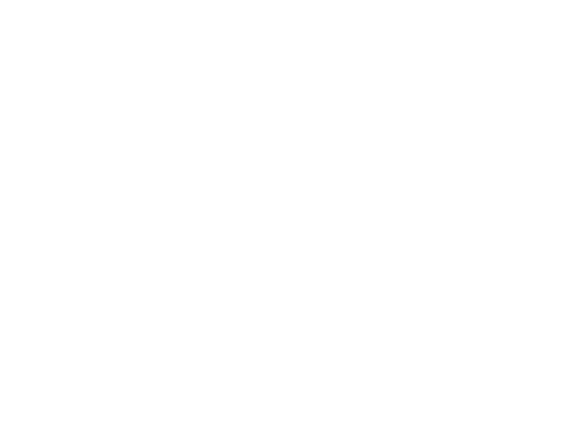

gov ks = [2.3545004863762538, 3.1762256106303335, 4.126996900496065, 4.126554281885824, 4.1267950679136725, 4.126333585561384, 3.176146624314502, 2.3545004863762538]
noz_k = 19.620837386468782
Iteration number 1
--- 12.69975757598877 seconds ---


<IPython.core.display.Javascript object>


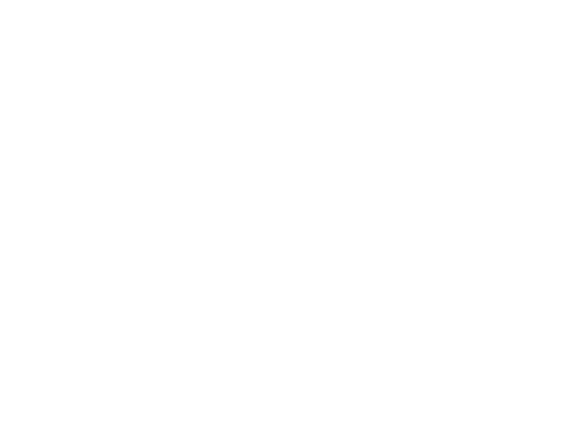

gov ks = [4.479573644899418, 4.479573644899418, 44.79573644899418, 44.79573644899418, 44.79573644899418, 44.79573644899418, 44.79573644899418, 4.479573644899418]
noz_k = 3.7329780374161814
Iteration number 2
--- 15.456936597824097 seconds ---


<IPython.core.display.Javascript object>


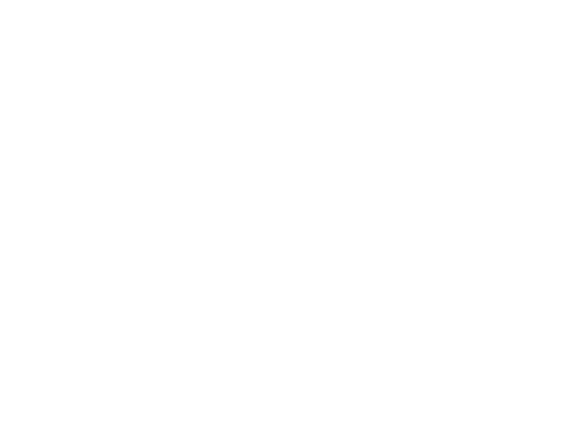

gov ks = [4.333180021632769, 43.331800216327686, 43.331800216327686, 43.331800216327686, 43.331800216327686, 4.333180021632769, 43.331800216327686, 43.331800216327686]
noz_k = 3.6109833513606406
Iteration number 3
--- 13.19774317741394 seconds ---


<IPython.core.display.Javascript object>


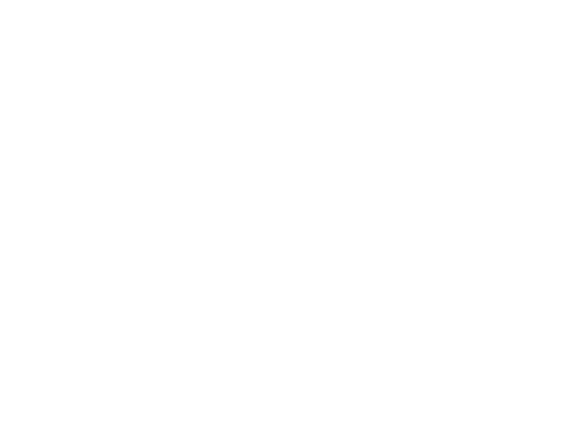

gov ks = [4.333180021632769, 43.331800216327686, 43.331800216327686, 43.331800216327686, 43.331800216327686, 4.333180021632769, 43.331800216327686, 43.331800216327686]
noz_k = 3.6109833513606406
Iteration number 4
--- 14.69886589050293 seconds ---


<IPython.core.display.Javascript object>


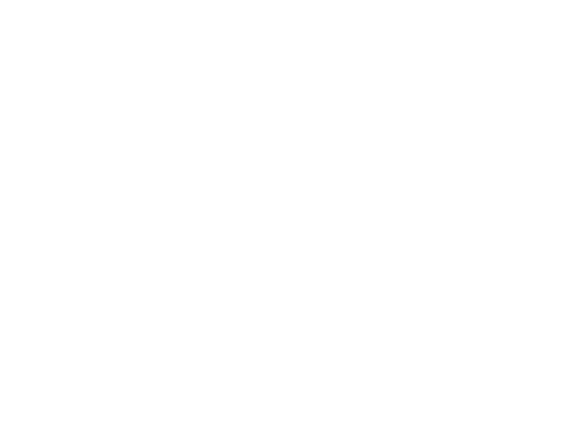

gov ks = [4.333180021632769, 43.331800216327686, 43.331800216327686, 43.331800216327686, 43.331800216327686, 4.333180021632769, 43.331800216327686, 43.331800216327686]
noz_k = 3.6109833513606406
Iteration number 5
--- 21.707430124282837 seconds ---


<IPython.core.display.Javascript object>


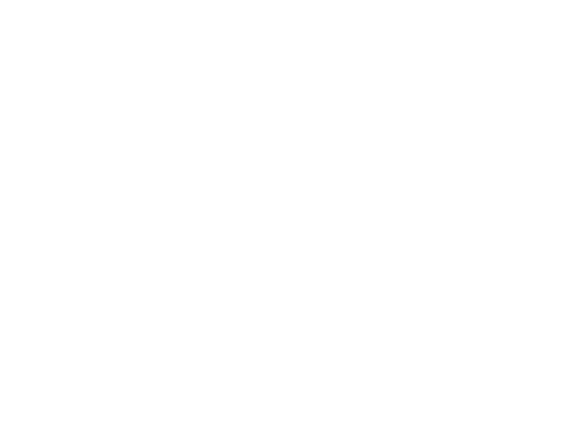

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 6
--- 18.298798084259033 seconds ---


<IPython.core.display.Javascript object>


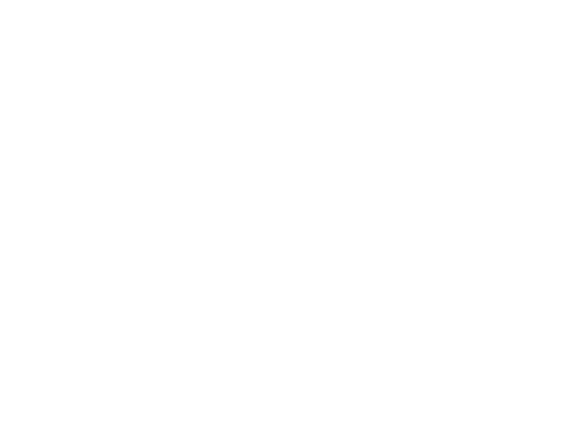

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 7
--- 19.860743522644043 seconds ---


<IPython.core.display.Javascript object>


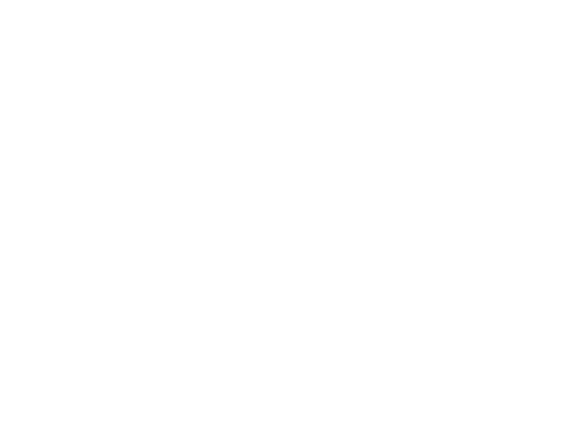

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 8
--- 21.460875749588013 seconds ---


<IPython.core.display.Javascript object>


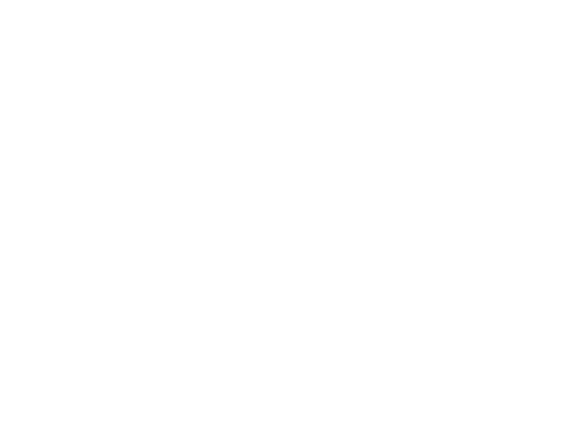

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 9
--- 23.244638442993164 seconds ---


<IPython.core.display.Javascript object>


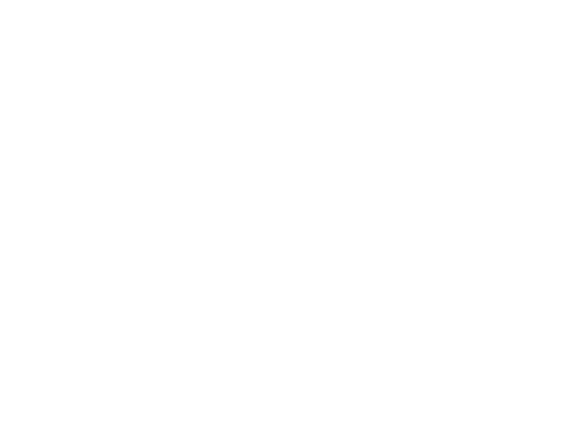

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 10
--- 24.608905792236328 seconds ---


<IPython.core.display.Javascript object>


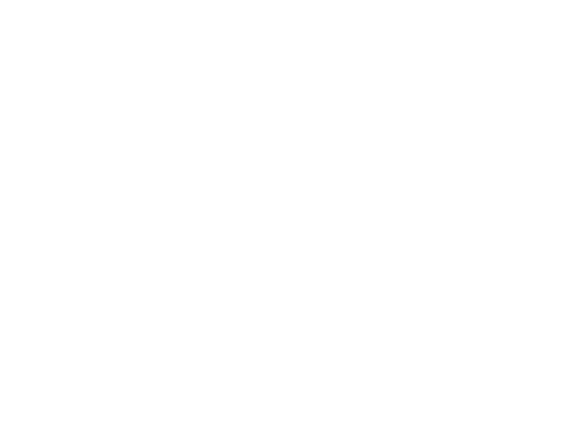

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 11
--- 26.040936946868896 seconds ---


<IPython.core.display.Javascript object>


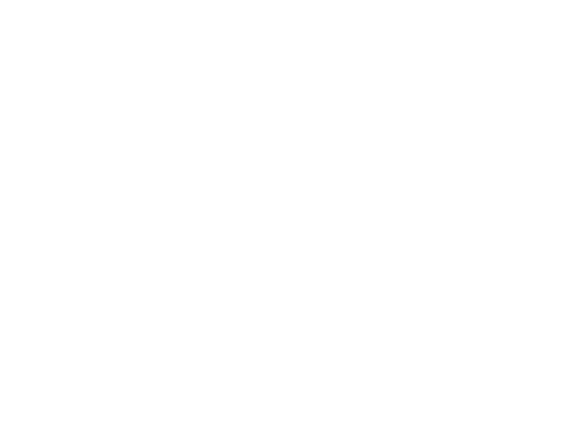

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 12
--- 28.552133083343506 seconds ---


<IPython.core.display.Javascript object>


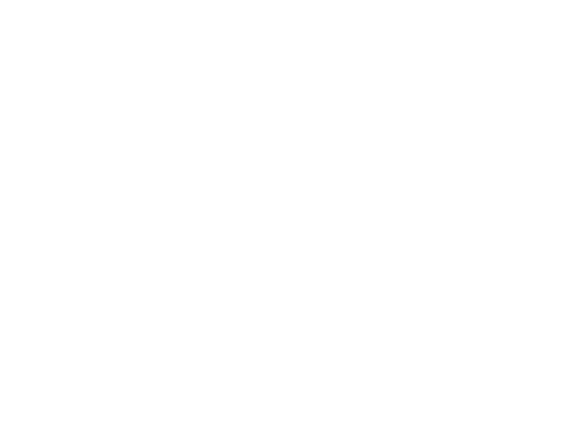

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 13
--- 30.208409547805786 seconds ---


<IPython.core.display.Javascript object>


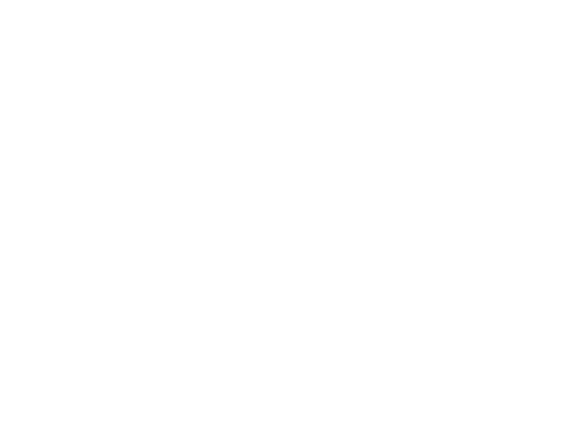

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 14
--- 31.66935396194458 seconds ---


<IPython.core.display.Javascript object>


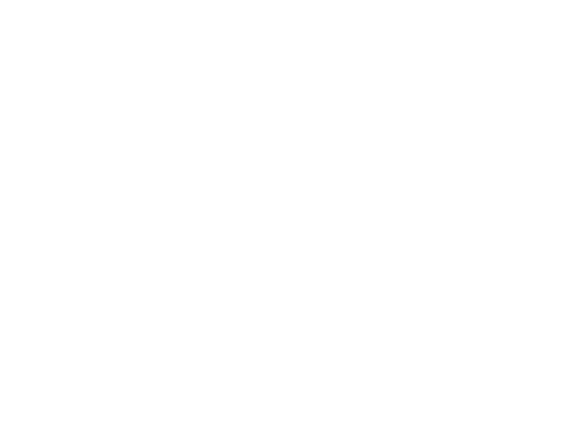

gov ks = [4.479573644899417, 44.79573644899416, 44.79573644899416, 44.79573644899416, 4.479573644899417, 4.479573644899417, 44.79573644899416, 44.79573644899416]
noz_k = 3.7329780374161805
Iteration number 15
--- 43.254249572753906 seconds ---


<IPython.core.display.Javascript object>


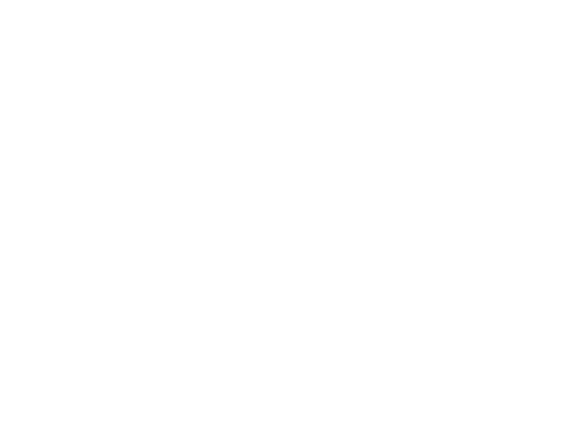

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 16
--- 36.89134168624878 seconds ---


<IPython.core.display.Javascript object>


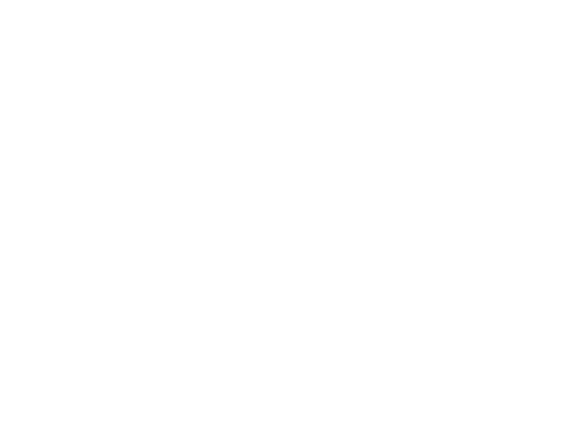

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 17
--- 36.71092391014099 seconds ---


<IPython.core.display.Javascript object>


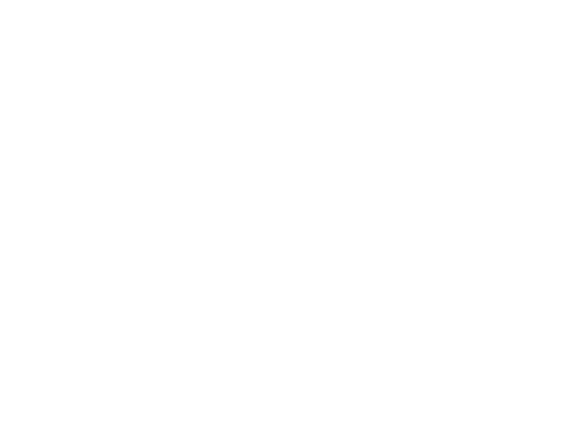

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 18
--- 39.352943897247314 seconds ---


<IPython.core.display.Javascript object>


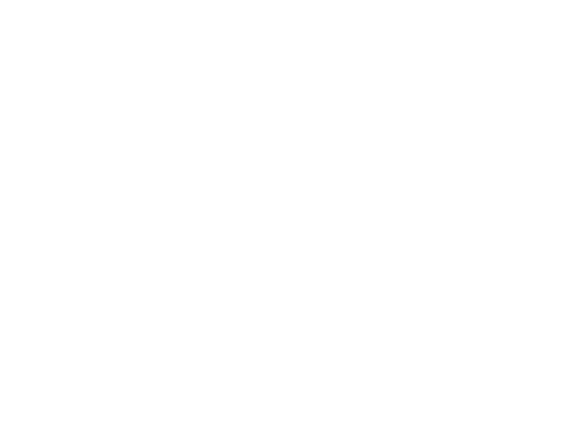

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 19
--- 41.02709627151489 seconds ---


<IPython.core.display.Javascript object>


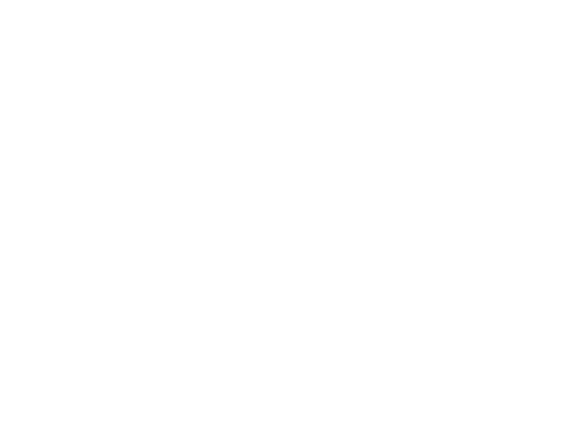

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 20
--- 41.07073712348938 seconds ---


<IPython.core.display.Javascript object>


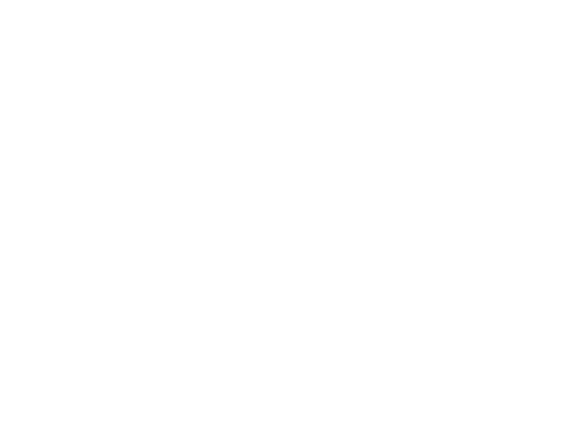

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 21
--- 43.03311562538147 seconds ---


<IPython.core.display.Javascript object>


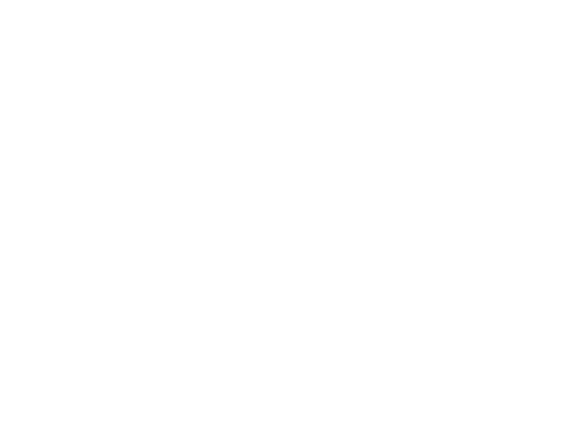

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 22
--- 44.77573204040527 seconds ---


<IPython.core.display.Javascript object>


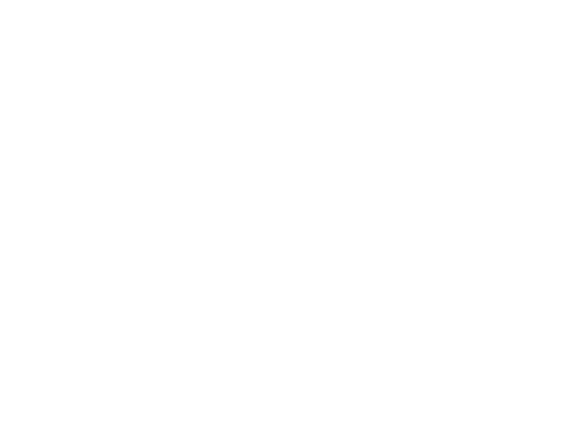

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 23
--- 45.58289909362793 seconds ---


<IPython.core.display.Javascript object>


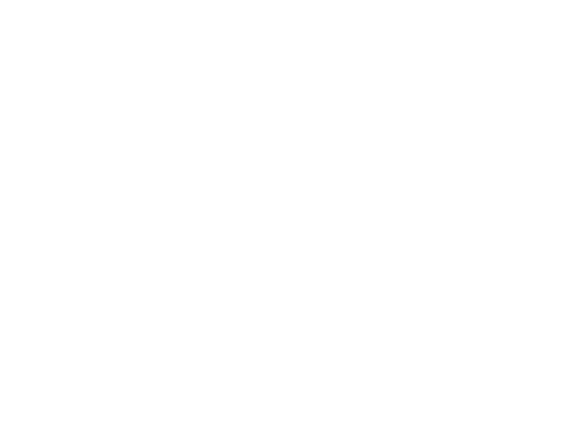

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 24
--- 47.23173689842224 seconds ---


<IPython.core.display.Javascript object>


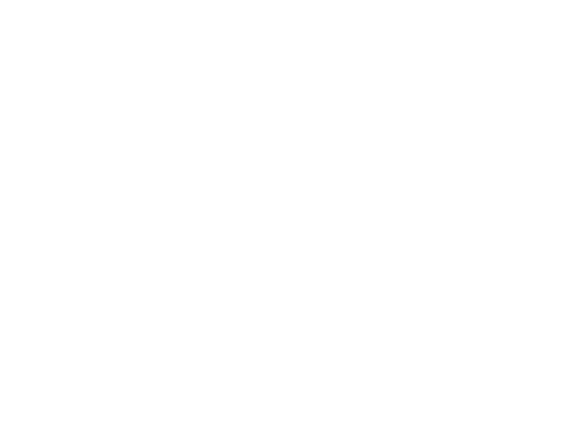

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 25
--- 48.90782308578491 seconds ---


<IPython.core.display.Javascript object>


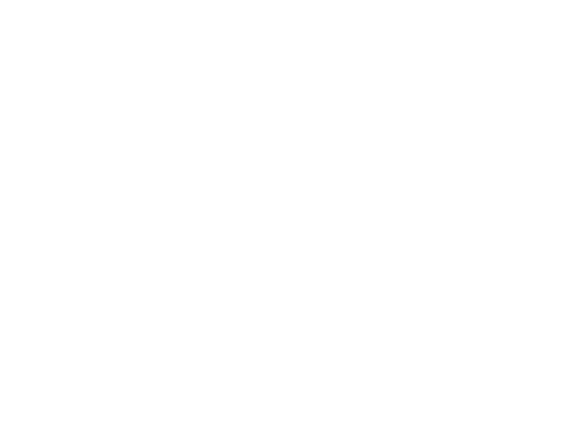

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 26
--- 50.88920879364014 seconds ---


<IPython.core.display.Javascript object>


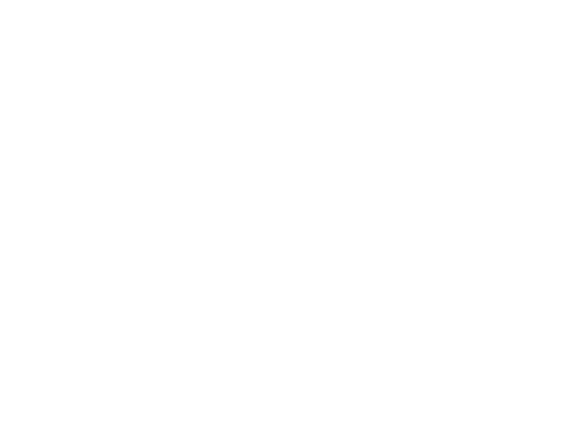

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 27
--- 52.50201344490051 seconds ---


<IPython.core.display.Javascript object>


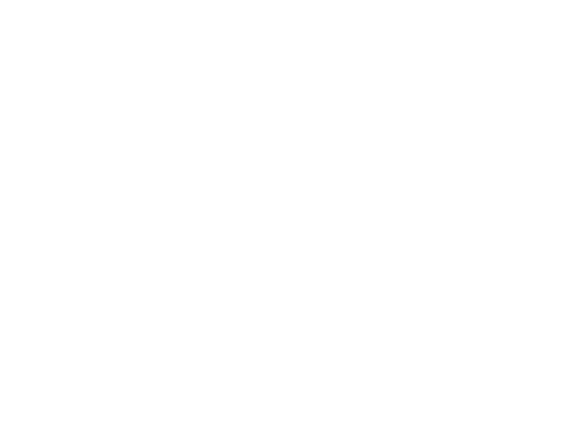

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 28
--- 54.31552052497864 seconds ---


<IPython.core.display.Javascript object>


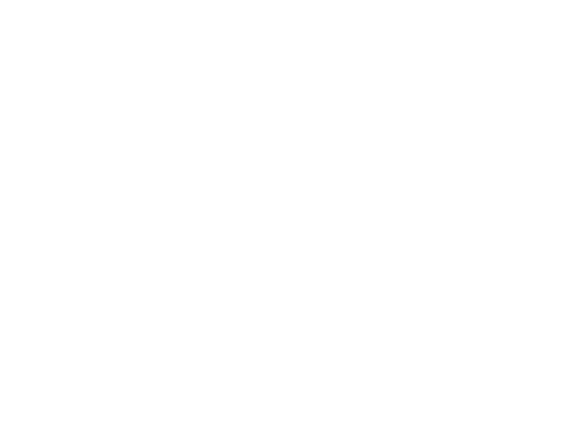

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 29
--- 58.77651762962341 seconds ---


<IPython.core.display.Javascript object>


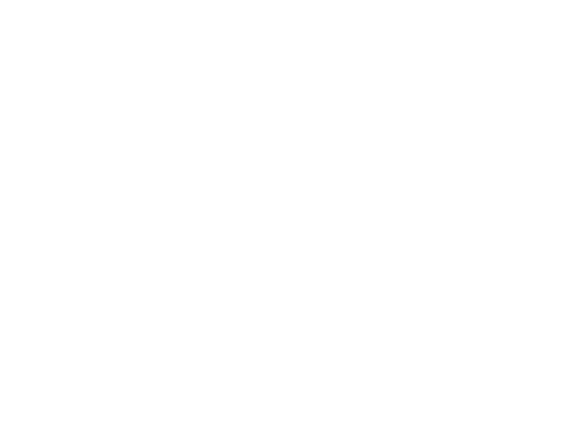

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 30
--- 61.0256667137146 seconds ---


<IPython.core.display.Javascript object>


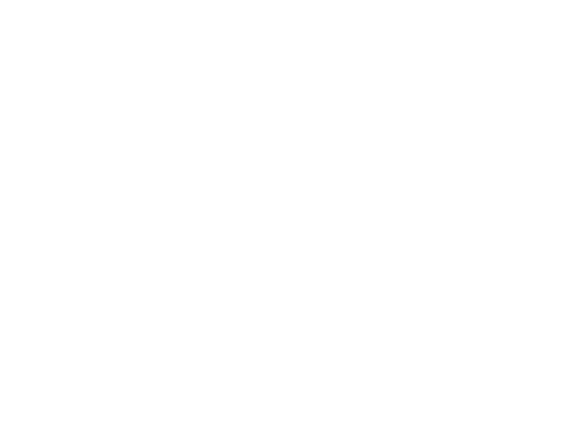

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 31
--- 61.65723776817322 seconds ---


<IPython.core.display.Javascript object>


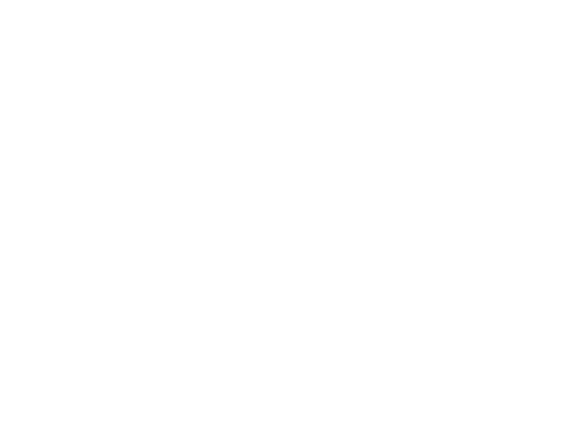

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 32
--- 62.2405481338501 seconds ---


<IPython.core.display.Javascript object>


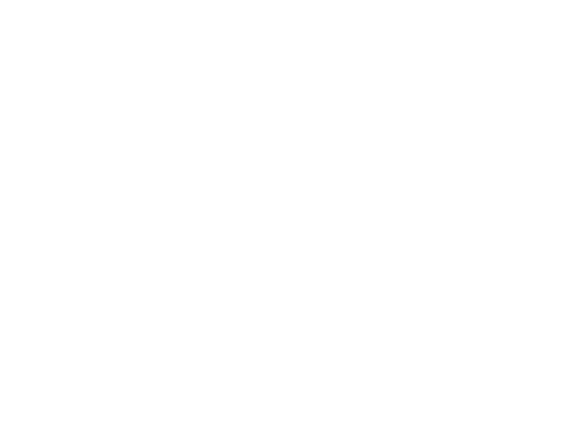

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 33
--- 64.14810824394226 seconds ---


<IPython.core.display.Javascript object>


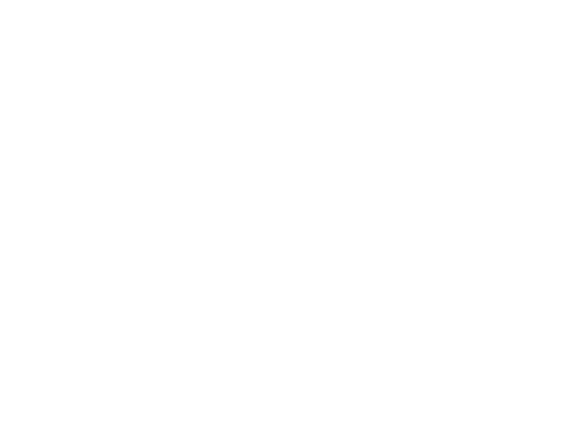

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 34
--- 67.76663136482239 seconds ---


<IPython.core.display.Javascript object>


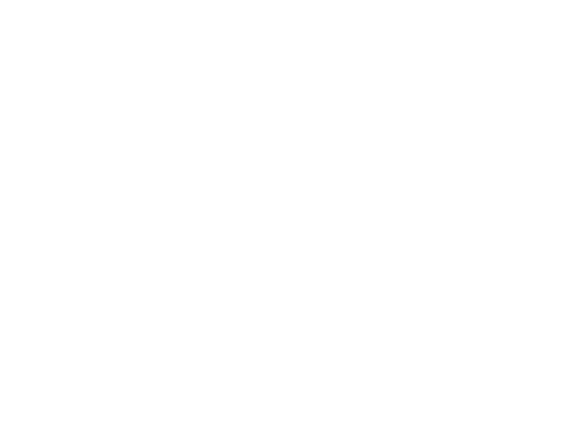

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 35
--- 71.97469305992126 seconds ---


<IPython.core.display.Javascript object>


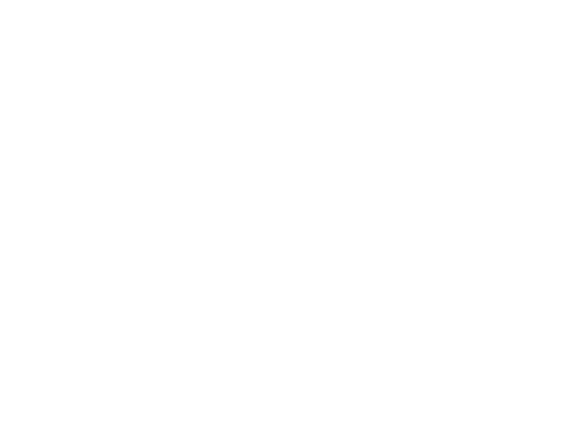

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 36
--- 74.42952919006348 seconds ---


<IPython.core.display.Javascript object>


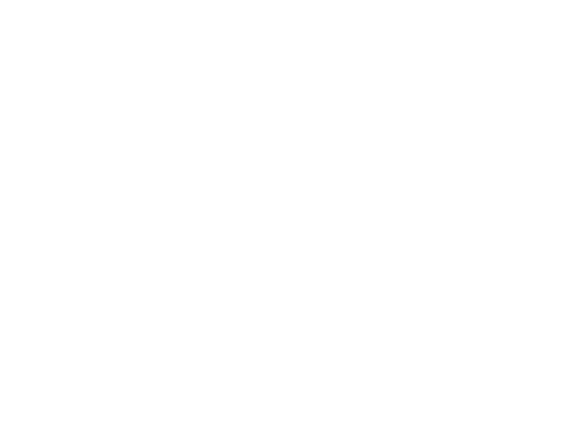

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 37
--- 72.97531008720398 seconds ---


<IPython.core.display.Javascript object>


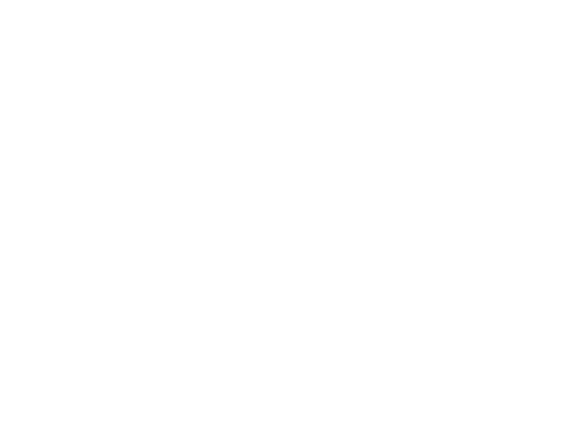

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 38
--- 72.24032855033875 seconds ---


<IPython.core.display.Javascript object>


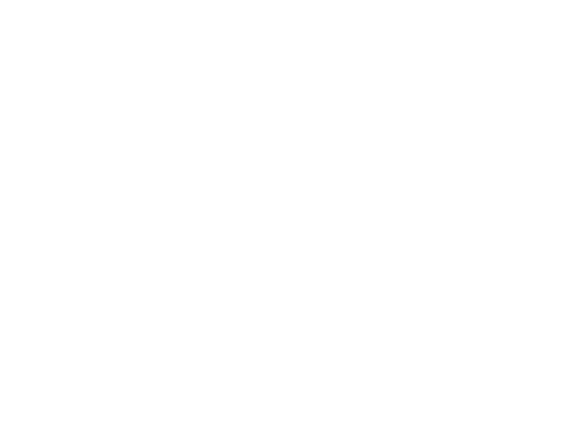

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 39
--- 73.25882911682129 seconds ---


<IPython.core.display.Javascript object>


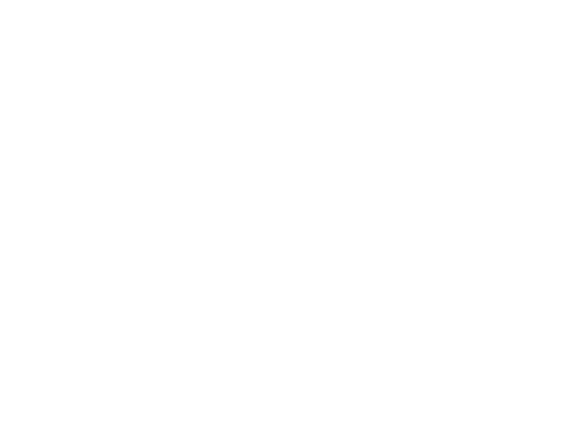

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 40
--- 75.23113489151001 seconds ---


<IPython.core.display.Javascript object>


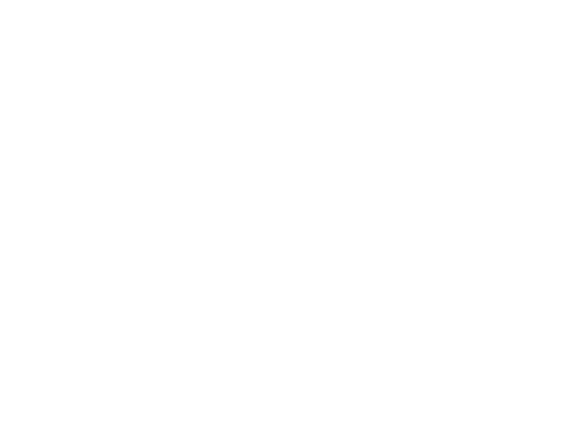

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 41
--- 78.60973501205444 seconds ---


<IPython.core.display.Javascript object>


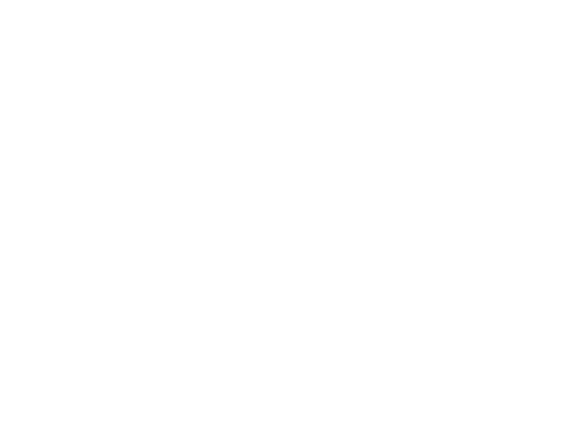

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 42
--- 79.12106394767761 seconds ---


<IPython.core.display.Javascript object>


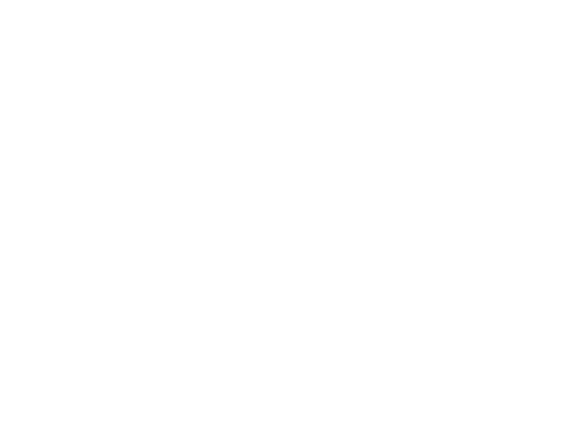

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 43
--- 76.95694279670715 seconds ---


<IPython.core.display.Javascript object>


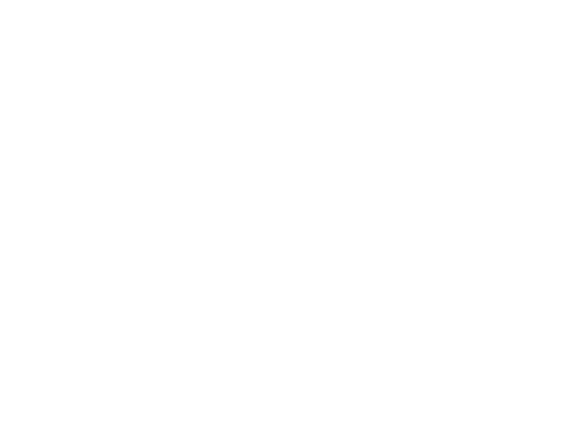

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 44
--- 80.1798186302185 seconds ---


<IPython.core.display.Javascript object>


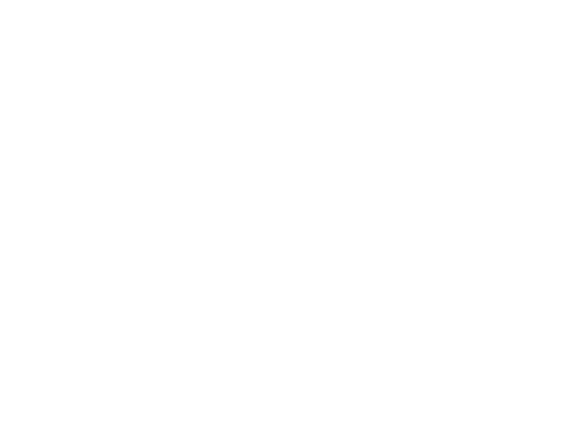

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 45
--- 79.55885362625122 seconds ---


<IPython.core.display.Javascript object>


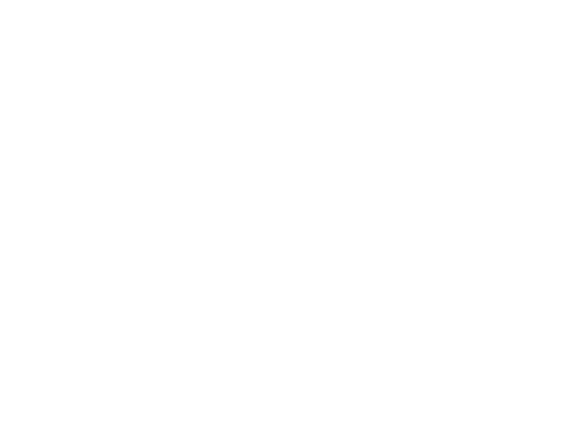

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 46
--- 80.82968306541443 seconds ---


<IPython.core.display.Javascript object>


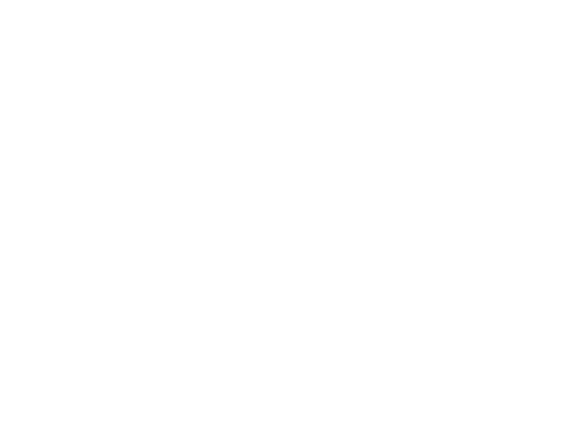

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 47
--- 82.73258709907532 seconds ---


<IPython.core.display.Javascript object>


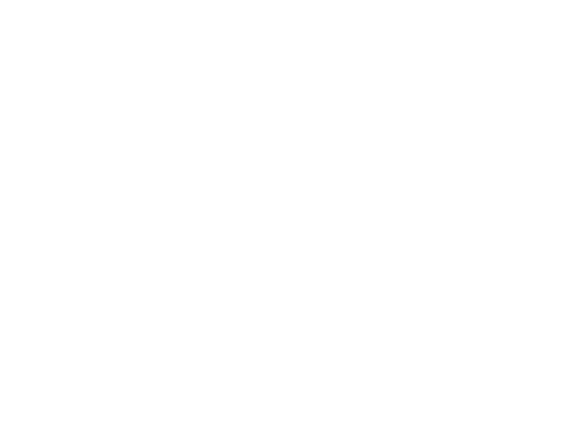

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 48
--- 84.26305508613586 seconds ---


<IPython.core.display.Javascript object>


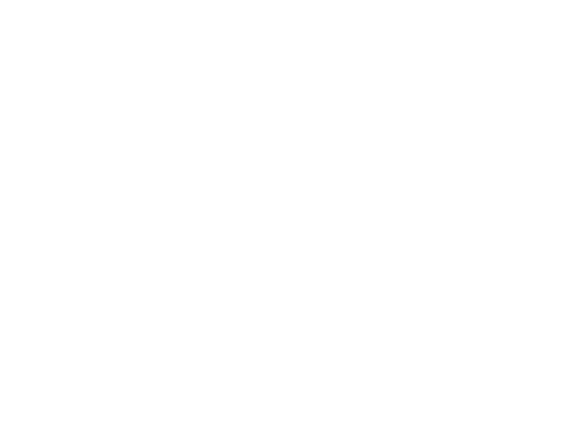

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 49
--- 86.88383865356445 seconds ---


<IPython.core.display.Javascript object>


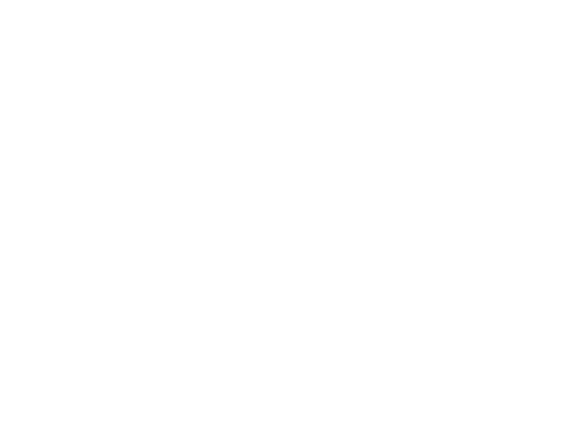

gov ks = [4.636204758639189, 46.36204758639189, 46.36204758639189, 46.36204758639189, 4.636204758639189, 4.636204758639189, 4.636204758639189, 46.36204758639189]
noz_k = 3.8635039655326575
Iteration number 50


In [58]:
# 5 iterations required: 30 seconds
# Initial performance 250 iterations / 86 sec = 2.9 iter/sec
# print only every 50 250 iterations / 76 = 3.2 iter sec
# Evaluate every 10% gv demand instead of every 1% 250 /12 = 20.83 iter sec
# 6900 iterations / 352 = 19.6

for y in range(50):
    
    # Define the governor demands to test against

    target_resolution = 3 + y*2
    gov_dmd = np.arange(0,100+100/target_resolution, 100/target_resolution).round(0)

    #Define the throttle pressure
    tp = np.interp(gov_dmd, tp_model_df["Governor Demand"], tp_model_df["Throttle Pressure"])

    #Define the steam temperatures
    temperature = np.interp(gov_dmd, steam_temp_model_df["Governor Demand"], steam_temp_model_df["Steam Temp"])

    #Define the inlet densities
    rho = []
    for x in range(len(gov_dmd)):
        rho.append(calc_rho(tp[x],temperature[x]))

    #Define the first stage pressures
    first_p = np.interp(gov_dmd, first_stage_model_df["Governor Demand"], first_stage_model_df["First Stage Pressure"])

    #Define the target steam flows
    flow_target = np.interp(gov_dmd, steam_flow_model_df["Governor Demand"], steam_flow_model_df["Steam Flow"])

    #Define the p_ratio
    p_ratio = first_p / tp

    dictionary = {
        "Governor Demand" : gov_dmd,
        "Throttle Pressure" : tp,
        "Main Steam Temp" : temperature,
        "Inlet Density" : rho,
        "First Stage Pressure" : first_p,
        "Steam Flow Target" : flow_target,
        "Px/Pi" : p_ratio
    }

    target_df = pd.DataFrame(dictionary)
    target_df.to_csv(f"projects/{project}/target_performance.csv")
    
    
    iteration = y+1
    start_time = time.time()
    result = optimize.dual_annealing(calc_performance, bounds, maxiter=1, x0 =initial_guess, args=(target_df, 0, iteration))
    results.append(result)
    print("--- %s seconds ---" % (time.time() - start_time))

    calc_performance(result['x'], target_df, 1, iteration)
    initial_guess = result['x']
    print(f'Iteration number {iteration}')
    im.append(PIL.Image.open(f"projects/{project}/plot{iteration}.png"))

im[0].save(f'projects/{project}/plot.gif', format='GIF', append_images=im[1:], save_all=True, duration=200, loop=1)

In [35]:
results

[     fun: 439260.5493072103
  message: ['Maximum number of iteration reached']
     nfev: 2309
     nhev: 0
      nit: 1
     njev: 0
        x: array([0.3488062 , 0.31928269, 0.83266076, 0.90226166, 0.46499766,
        0.70478053, 0.4395947 , 0.43095237, 0.88449554, 0.85347693,
        0.99968556, 0.99700924, 0.99968556, 0.99469096, 0.83032926,
        0.99968556, 0.88449556, 0.82381524, 0.79354373, 0.88525656,
        0.98084648, 0.96114973, 0.84224772, 0.89734533, 0.89734533,
        0.81877564, 0.93728876, 0.87367189, 0.93728876, 0.99887523,
        0.89021407, 0.8447662 , 0.9534685 , 0.9999839 , 0.92927125,
        0.92927125, 0.9534685 , 0.98577237, 0.93858697, 0.85039791,
        0.80618965, 0.99930792, 0.17183932, 0.841744  , 0.94407245,
        0.7983016 , 0.82243327, 0.85467067, 0.97656834, 0.7983016 ,
        0.7834286 , 0.86044819, 0.81688362, 0.99980305, 0.57478686,
        0.75543801, 0.97192967, 0.91473867, 0.84919936, 0.91473867,
        0.91426979, 0.99648351, 0.99985

<IPython.core.display.Javascript object>


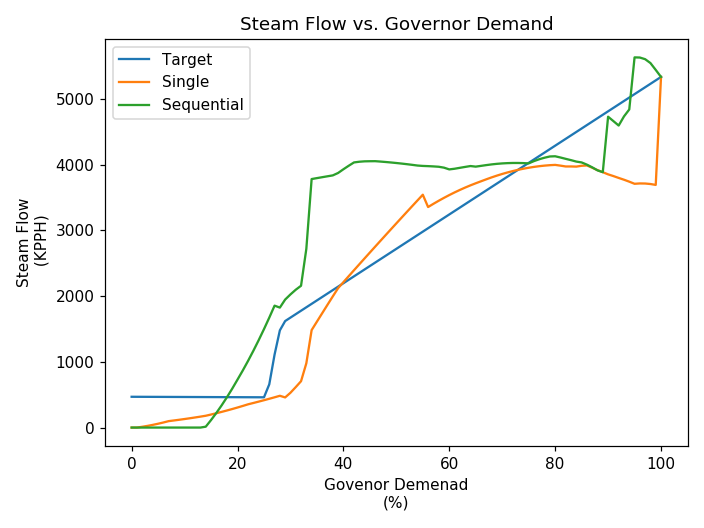

gov ks = [4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255, 4.885060566730255]
noz_k = 4.885060566730255


106209466.85586068

In [402]:
calc_performance(result['x'], target_df, 1, iteration)

In [25]:
gov_dmd.round(0)

array([  0.,   9.,  18.,  27.,  36.,  45.,  55.,  64.,  73.,  82.,  91.,
       100.])

In [391]:
result['x']

array([0.12746796, 0.11258759, 0.19120637, 0.11258759, 0.33796518,
       0.19120637, 0.98070916, 0.98317081, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.78765596,
       0.96771118, 0.96771119, 0.9677112 , 0.88699435, 0.        ,
       0.98620221, 0.99468324, 0.99468281, 0.99468283, 0.65236002,
       0.        , 0.9433956 , 0.94339561, 0.94339558, 0.94339559,
       0.7992916 , 0.        , 0.99501228, 0.99501207, 0.99501212,
       0.98008002, 0.65578503, 0.        , 0.93512694, 0.93512704,
       0.93512709, 0.93512705, 0.82800367, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.55247587])

<IPython.core.display.Javascript object>


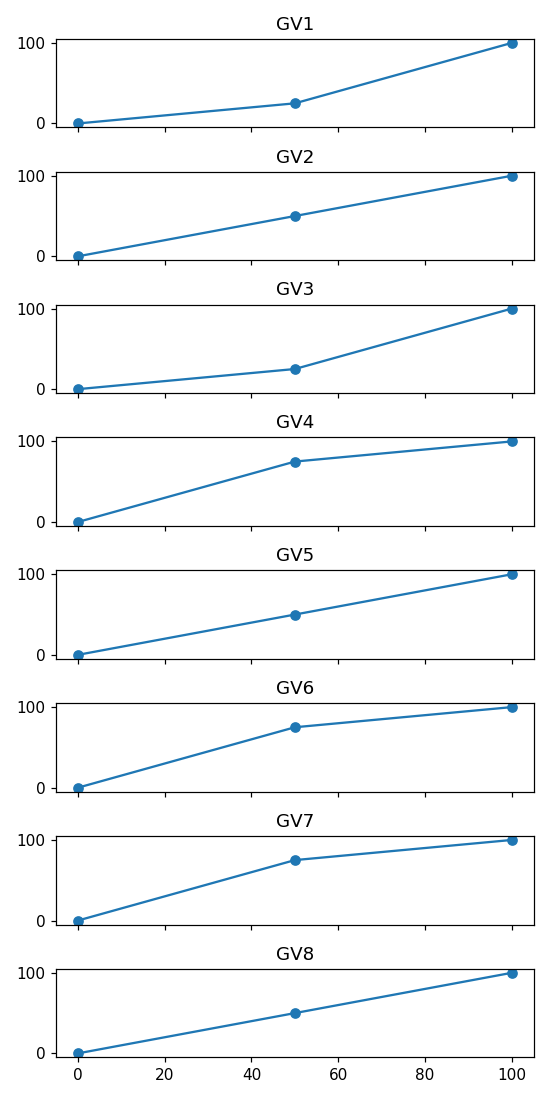

In [139]:
#show best trim curves
trim_df
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, sharex=True, figsize = (5,10))

ax1.plot(trim_df[f"GV1 lift"], trim_df[f"GV1 area"],"-o")
ax2.plot(trim_df[f"GV2 lift"], trim_df[f"GV2 area"],"-o")
ax3.plot(trim_df[f"GV3 lift"], trim_df[f"GV3 area"],"-o")
ax4.plot(trim_df[f"GV4 lift"], trim_df[f"GV4 area"],"-o")
ax5.plot(trim_df[f"GV5 lift"], trim_df[f"GV5 area"],"-o")
ax6.plot(trim_df[f"GV6 lift"], trim_df[f"GV6 area"],"-o")
ax7.plot(trim_df[f"GV7 lift"], trim_df[f"GV7 area"],"-o")
ax8.plot(trim_df[f"GV8 lift"], trim_df[f"GV8 area"],"-o")

ax1.set_title('GV1')
ax2.set_title('GV2')
ax3.set_title('GV3')
ax4.set_title('GV4')
ax5.set_title('GV5')
ax6.set_title('GV6')
ax7.set_title('GV7')
ax8.set_title('GV8')
plt.tight_layout()
plt.show()
                                          
fig.savefig(f'projects/{project}/final_trims.png')

In [48]:
import math
-math.log10(0.1)

1.0